source: https://www.kaggle.com/code/robikscube/train-your-first-pytorch-model-card-classifier#Bonus:-Evaluating-the-Results

In [1]:
# Pytorch
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import Dataset, DataLoader

# Torchvision: make working with image files easier
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# progress bar
from tqdm import tqdm 

# optimizer
import torch.optim as optim

# scikit-learn
from sklearn.metrics import accuracy_score
import numpy as np

import matplotlib.pyplot as plt

In [2]:
class SyntheticDataClassifier(nn.Module):
    def __init__(self, num_classes=2, weights='DEFAULT'):
        super(SyntheticDataClassifier, self).__init__()
        self.model = resnet18(weights=weights)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)  # Modify the last fully connected layer
    
    def forward(self, x):
        return self.model(x)

In [3]:
class SyntheticDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = ImageFolder(data_dir, transform=transform) # ImageFolder automatically assigns labels based on folder structure
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes # returns dataset classes from ImageFolder

In [4]:
#  Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformation operation that suits resnet18
weights = ResNet18_Weights.DEFAULT
transform_operation = weights.transforms()
print(transform_operation)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [5]:
# # Define data augmentation transformations
# resnet_default = transform_operation
# data_augmentation = transforms.Compose([
#     transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
#     transforms.RandomRotation(degrees=15),  # Randomly rotate the image within ±15 degrees
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
# ])

# # Combine data augmentation and transformation suitable for ResNet18
# transform_operation = transforms.Compose([
#     data_augmentation,
#     resnet_default
# ])

# Create a dataset object
train_dataset = SyntheticDataset(data_dir='dataset\\train', transform=transform_operation)
test_dataset = SyntheticDataset(data_dir='dataset\\test', transform=transform_operation)
val_dataset = SyntheticDataset(data_dir='dataset\\val', transform=transform_operation)

# Create a DataLoader object for training - faster training in batches
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) 
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# size of the training dataset
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 972
Validation dataset size: 203
Test dataset size: 111


In [6]:
# Get a dictionary associating target values with folder names
data_dir = 'dataset\\train'
target_to_class = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'bad', 1: 'good'}


In [7]:
model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)  

# Training (already done)

In [100]:
# Training the model

num_epochs = 15
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model = SyntheticDataClassifier(num_classes=2, weights=weights).to(device)    
model.to(device)
    
criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-6)

for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_preds, train_labels = [], []
        for images, labels in tqdm(train_loader, desc='Training loop'):
            # Move inputs and labels to the device
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * labels.size(0)
            
            _, predicted = torch.max(outputs, 1)
            train_preds.extend(predicted.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_accuracies.append(train_accuracy)

        
        # Validation phase
        model.eval()
        running_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc='Validation loop'):
                # Move inputs and labels to the device
                images, labels = images.to(device), labels.to(device)
            
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * labels.size(0)
                
                _, predicted = torch.max(outputs, 1)
                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
                
        val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_accuracies.append(val_accuracy)
        
        torch.save(model.state_dict(), f'models\\model_epoch_{epoch+1}.pth')
        
        print(f"Epoch {epoch+1}/{num_epochs} - Train loss: {train_loss}, Validation loss: {val_loss}")
        print(f"Epoch {epoch+1}/{num_epochs} - Train accuracy: {train_accuracy}, Validation accuracy: {val_accuracy}")

Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.84it/s]


Epoch 1/15 - Train loss: 0.8215402330390711, Validation loss: 0.7873009918945764
Epoch 1/15 - Train accuracy: 0.5020576131687243, Validation accuracy: 0.5024630541871922


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.47it/s]


Epoch 2/15 - Train loss: 0.7265641318917765, Validation loss: 0.7458659397263833
Epoch 2/15 - Train accuracy: 0.5483539094650206, Validation accuracy: 0.5270935960591133


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.14it/s]


Epoch 3/15 - Train loss: 0.6635750322430222, Validation loss: 0.6986743239640015
Epoch 3/15 - Train accuracy: 0.6018518518518519, Validation accuracy: 0.5665024630541872


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.01it/s]


Epoch 4/15 - Train loss: 0.6033234174359482, Validation loss: 0.6782633682777142
Epoch 4/15 - Train accuracy: 0.6666666666666666, Validation accuracy: 0.5862068965517241


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.82it/s]


Epoch 5/15 - Train loss: 0.5607116482385393, Validation loss: 0.6601085031561076
Epoch 5/15 - Train accuracy: 0.7129629629629629, Validation accuracy: 0.6108374384236454


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.97it/s]


Epoch 6/15 - Train loss: 0.5114268660545349, Validation loss: 0.6377737225570115
Epoch 6/15 - Train accuracy: 0.7788065843621399, Validation accuracy: 0.6305418719211823


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.27it/s]


Epoch 7/15 - Train loss: 0.4815265384230594, Validation loss: 0.6151850895928632
Epoch 7/15 - Train accuracy: 0.7973251028806584, Validation accuracy: 0.6798029556650246


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.49it/s]


Epoch 8/15 - Train loss: 0.4416585808673513, Validation loss: 0.6141646864085362
Epoch 8/15 - Train accuracy: 0.831275720164609, Validation accuracy: 0.6748768472906403


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.22it/s]


Epoch 9/15 - Train loss: 0.4079044993522236, Validation loss: 0.595553477409438
Epoch 9/15 - Train accuracy: 0.8611111111111112, Validation accuracy: 0.6600985221674877


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]


Epoch 10/15 - Train loss: 0.37135583493444657, Validation loss: 0.5947245895275342
Epoch 10/15 - Train accuracy: 0.897119341563786, Validation accuracy: 0.6847290640394089


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]


Epoch 11/15 - Train loss: 0.3436359108230214, Validation loss: 0.5848071133268291
Epoch 11/15 - Train accuracy: 0.9135802469135802, Validation accuracy: 0.6798029556650246


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.16it/s]


Epoch 12/15 - Train loss: 0.31820180926303315, Validation loss: 0.5846665629318782
Epoch 12/15 - Train accuracy: 0.9372427983539094, Validation accuracy: 0.6896551724137931


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  5.18it/s]


Epoch 13/15 - Train loss: 0.3022567344055254, Validation loss: 0.5783311588129973
Epoch 13/15 - Train accuracy: 0.9331275720164609, Validation accuracy: 0.6995073891625616


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.99it/s]


Epoch 14/15 - Train loss: 0.27222247636367264, Validation loss: 0.5687832675250293
Epoch 14/15 - Train accuracy: 0.9516460905349794, Validation accuracy: 0.6896551724137931


Validation loop: 100%|██████████| 7/7 [00:01<00:00,  4.15it/s]

Epoch 15/15 - Train loss: 0.24273622857690347, Validation loss: 0.570214642973369
Epoch 15/15 - Train accuracy: 0.9619341563786008, Validation accuracy: 0.6847290640394089


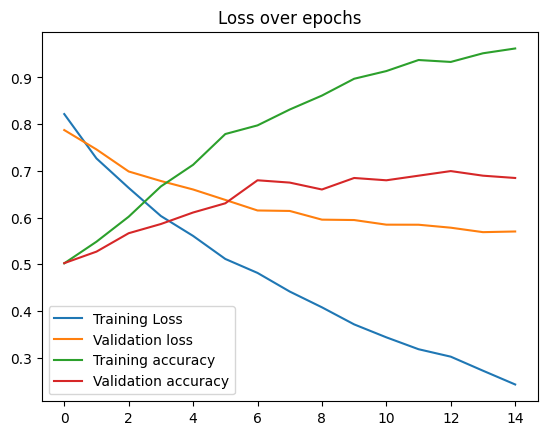

In [101]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation loss')
plt.plot(train_accuracies, label='Training accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.legend()
plt.title('Loss over epochs')
plt.show()

# Select the saved model for inference

In [8]:
# Load the saved model state dictionary from the .pth file
checkpoint_path = 'models\\model_709.pth'  # Adjust the path as per your saved model file
checkpoint = torch.load(checkpoint_path)

# Load the state dictionary into the model
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [16]:
model.eval() # Set the model to evaluation mode (turns off dropout and batch normalization)

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Disable gradient computation
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Move images and labels to the device (assuming you're using GPU)
        images, labels = images.cuda(), labels.cuda()
        
        # Forward pass
        outputs = model(images)
        
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        
        # Total number of labels
        total += labels.size(0)
        
        # SKLEARN -> precision and accuracy classification report
        
        # Total correct predictions
        correct += (predicted == labels).sum().item()

# Calculate accuracy
accuracy = 100 * correct / total
print('Accuracy on the test set: {:.2f}%'.format(accuracy))

100%|██████████| 4/4 [00:01<00:00,  3.31it/s]

Accuracy on the test set: 72.07%


# Inference

In [9]:
# Load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
    return probabilities.cpu().numpy().flatten()

In [10]:
# Visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    
    # Display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

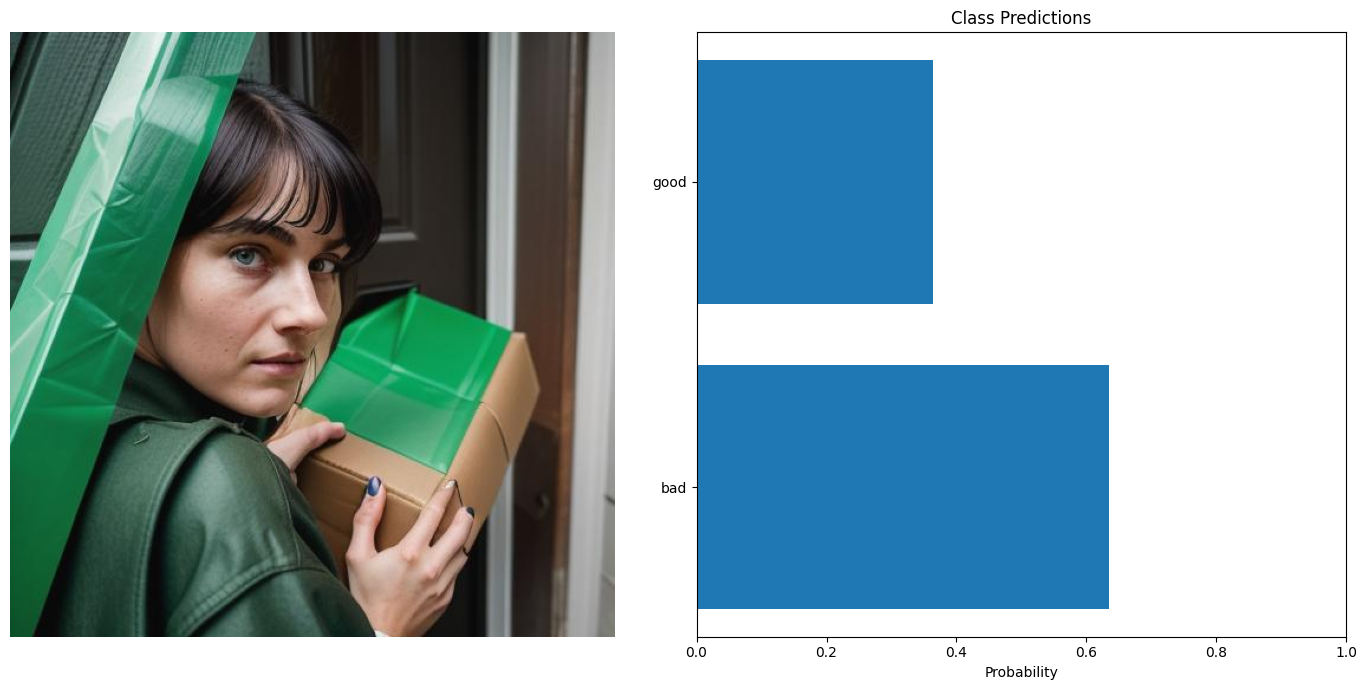

[0.635415   0.36458495]


In [13]:
from PIL import Image
# Example usage
test_image = "sort_images\\7.jpg"
original_image, image_tensor = preprocess_image(test_image, transform_operation) # determined earlier in the code
probabilities = predict(model, image_tensor, device)

# Assuming dataset.classes gives the class names
class_names = train_dataset.classes 
visualize_predictions(original_image, probabilities, class_names)
print(probabilities)

In [14]:
# Run inference write to directory
import os

directory = 'sort_images\\'
files = os.listdir(directory)
# sorted_files = sorted(files, key=lambda x: (int(x.split('_')[0]), int(x.split('_')[1].split('.')[0])))
sorted_files = sorted(files, key=lambda x: (int(x.split('.')[0])))
print(sorted_files)

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg', '6.jpg', '7.jpg', '8.jpg', '9.jpg', '10.jpg', '11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg', '16.jpg', '17.jpg', '18.jpg', '19.jpg', '20.jpg', '21.jpg', '22.jpg', '23.jpg', '24.jpg', '25.jpg', '26.jpg', '27.jpg', '28.jpg', '29.jpg', '30.jpg', '31.jpg', '32.jpg', '33.jpg', '34.jpg', '35.jpg', '36.jpg', '37.jpg', '38.jpg', '39.jpg', '40.jpg', '41.jpg', '42.jpg', '43.jpg', '44.jpg', '45.jpg', '46.jpg', '47.jpg', '48.jpg', '49.jpg', '50.jpg', '51.jpg', '52.jpg', '53.jpg', '54.jpg', '55.jpg', '56.jpg', '57.jpg', '58.jpg', '59.jpg', '60.jpg', '61.jpg', '62.jpg', '63.jpg', '64.jpg', '65.jpg', '66.jpg', '67.jpg', '68.jpg', '69.jpg', '70.jpg', '71.jpg', '72.jpg', '73.jpg', '74.jpg', '75.jpg', '76.jpg', '77.jpg', '78.jpg', '79.jpg', '80.jpg', '81.jpg', '82.jpg', '83.jpg', '84.jpg', '85.jpg', '86.jpg', '87.jpg', '88.jpg', '89.jpg', '90.jpg', '91.jpg', '92.jpg', '93.jpg', '94.jpg', '95.jpg', '96.jpg', '97.jpg', '98.jpg', '99.jpg', '100.jpg'

In [15]:
for file in sorted_files:
    
    original_image, image_tensor = preprocess_image("sort_images\\" + file, transform_operation) # determined earlier in the code
    probabilities = predict(model, image_tensor, device)
    print(probabilities)
    
    if probabilities[1] > probabilities[0]:
        print(f"Image {file} is good, writing to good directory")
        original_image.save(f'results\\good\\{file}')
    else:
        print(f"Image {file} is bad, writing to bad directory")
        original_image.save(f'results\\bad\\{file}')

[0.65310293 0.3468971 ]
Image 0.jpg is bad, writing to bad directory
[0.291751 0.708249]
Image 1.jpg is good, writing to good directory
[0.2029151 0.7970849]
Image 2.jpg is good, writing to good directory
[0.3706557 0.6293443]
Image 3.jpg is good, writing to good directory
[0.28634924 0.71365076]
Image 4.jpg is good, writing to good directory
[0.35989025 0.6401097 ]
Image 5.jpg is good, writing to good directory
[0.6346447  0.36535534]
Image 6.jpg is bad, writing to bad directory
[0.635415   0.36458495]
Image 7.jpg is bad, writing to bad directory
[0.28152165 0.7184783 ]
Image 8.jpg is good, writing to good directory
[0.42646974 0.57353026]
Image 9.jpg is good, writing to good directory
[0.39120758 0.6087924 ]
Image 10.jpg is good, writing to good directory
[0.3990634  0.60093653]
Image 11.jpg is good, writing to good directory
[0.23235896 0.76764107]
Image 12.jpg is good, writing to good directory
[0.3258611 0.6741389]
Image 13.jpg is good, writing to good directory
[0.4008343 0.59916